In [1]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
tileIndMat_DIR = "tileIndMat"

In [4]:
cd exactOutput/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/exactOutput


In [11]:
# for objid in object_lst:
#     gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
#     print gammas

```
python -i  runRandTileTraining.py
```

if pick 10k tiles combo then takes around 3.5 hrs 

3000 tiles combo takes about 2 hrs


In [29]:
df = pd.read_csv("area_based_tile_combo_metric.csv",index_col=0)
df = df[df["Total gamma value"]!=0]

In [30]:
df.head()

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,Precision,Recall
9000,4,"[923, 1081, 2346, 1729, 731, 922, 1638, 1946, ...",399,36.272727,10.045276,0.913207,2511.223713,228.293065,0.986665,0.768581
9001,4,"[2278, 731, 922, 1594, 1638, 1946]",216,36.000000,5.973172,0.995529,81.584422,13.597404,0.976143,0.021442
9002,4,"[1729, 2278, 731, 1638, 1717, 1946, 1022, 755,...",390,35.454545,10.957409,0.996128,131.031539,11.911958,0.913698,0.035421
9003,4,"[923, 1081, 1690, 922, 1594, 767, 1717, 978, 1...",362,32.909091,9.064385,0.824035,2473.264807,224.842255,0.985034,0.760300
9004,4,"[923, 2278, 1594, 767, 1717, 1946, 1022, 801, ...",319,35.444444,8.109339,0.901038,2340.560977,260.062331,0.986799,0.728601


In [72]:
tile_subset_idx = tile_area_ratio.argsort()[::-1][:40]

In [74]:
# a much faster implementation 
rand_subset =[]
for i in range(3000):
    NumTilesInCombo= np.random.randint(0,40)
    tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
    rand_subset.append(tidxInCombo)

- compare subset results with individual worker PR 

In [82]:
mega_wlst=[]
mega_plst=[]
mega_rlst=[]
mega_objid=[]
for objid in tqdm(object_lst):
    wlst,plst,rlst = compute_worker_PR_obj(objid,return_worker_id=True)
    mega_objid.extend(objid*np.ones_like(wlst))
    mega_wlst.extend(wlst)
    mega_plst.extend(plst)
    mega_rlst.extend(rlst)

In [89]:
workerPR = pd.DataFrame(zip(mega_objid,mega_wlst,mega_plst,mega_rlst),columns=["objid","worker_id","Precision","Recall"])

# Correlation between variables

In [33]:
correlation = df[df.keys()[2:]].corr('pearson')
correlation

,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,Precision,Recall
Total Votes,1.000000,0.807416,0.895006,0.681353,-0.159418,-0.266912,0.660362,0.342521
Average Votes,0.807416,1.000000,0.708110,0.848125,-0.327338,-0.325439,0.802463,0.221482
Total gamma value,0.895006,0.708110,1.000000,0.826960,-0.125708,-0.232496,0.576157,0.177387
Average gamma value,0.681353,0.848125,0.826960,1.000000,-0.276286,-0.281104,0.673095,0.010758
Total area,-0.159418,-0.327338,-0.125708,-0.276286,1.000000,0.948169,-0.404372,0.255191
Average area,-0.266912,-0.325439,-0.232496,-0.281104,0.948169,1.000000,-0.398776,0.203657
Precision,0.660362,0.802463,0.576157,0.673095,-0.404372,-0.398776,1.000000,0.288174
Recall,0.342521,0.221482,0.177387,0.010758,0.255191,0.203657,0.288174,1.000000


<matplotlib.colorbar.Colorbar instance at 0x1181b4cf8>

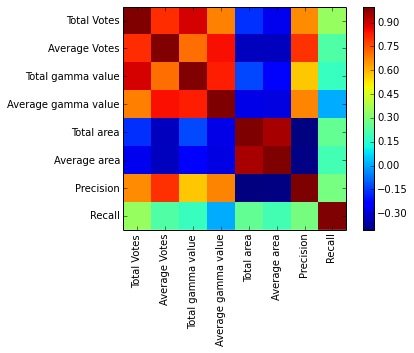

In [34]:
plt.imshow(correlation.as_matrix(),interpolation="None")
ticks=np.arange(0,8)
plt.xticks(ticks, df.keys()[2:], rotation='vertical')
plt.yticks(ticks, df.keys()[2:], rotation='horizontal')
plt.colorbar()

- the obvious things are that:
    - average and sum are correlated
    - identity along diagonal is correlated
- surprisingly, area is only weakly correlated with recall
- Total votes and total gamma values are strongly correlated as we expected
- Both total votes and total gamma values are strongly correlated with recall value

# Regression for ground truth PR

In [36]:
#x_attr = ["Average Votes","Average gamma value","Average area"]
x_attr=df.keys()[2:-2]
print x_attr
y_attr = ["Precision","Recall"]
print y_attr

Index([u'Total Votes', u'Average Votes', u'Total gamma value',
       u'Average gamma value', u'Total area', u'Average area'],
      dtype='object')
['Precision', 'Recall']


In [38]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [39]:
msk = np.random.rand(len(df)) < 0.8
Xtrain = df[x_attr][msk].as_matrix()
Xtest = df[x_attr][~msk].as_matrix()
Ytrain = df[y_attr][msk].as_matrix()
Ytest = df[y_attr][~msk].as_matrix()

In [40]:
regr.fit(Xtrain,Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(Xtest) - Ytest) ** 2))
print('R^2: %.2f' % regr.score(Xtest, Ytest))

('Coefficients: \n', array([[ -6.61698139e-04,   3.63140082e-02,   4.38833326e-02,
         -4.62497438e-01,  -2.19295091e-05,   5.72286237e-05],
       [ -1.22152771e-03,   3.63847107e-02,   9.11296920e-02,
         -1.59887830e+00,   2.15047753e-05,   2.66464464e-06]]))
Mean squared error: 0.04
R^2: 0.55


In [43]:
X = df[x_attr].as_matrix()
Y = df[y_attr].as_matrix()

In [44]:
regr.fit(X,Y)
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ -6.71182339e-04,   3.63557444e-02,   4.45491773e-02,
         -4.67089760e-01,  -2.24517216e-05,   6.48738180e-05],
       [ -1.19440758e-03,   3.60566339e-02,   9.05399436e-02,
         -1.59085566e+00,   2.06719579e-05,   1.10393625e-05]]))


In [45]:
print np.mean(df["Precision"])
print np.mean(df["Recall"])

0.742661878919
0.534664184458


#### $\therefore$ Average gamma value more important in determining actual PR compared to average area or average votes of the selected tiles , results qualitatively agree with our lossy BB2Tile algorithm

In [46]:
combined_df = df["Precision"]+df["Recall"]

In [47]:
df.sort(columns=["Precision","Recall"],ascending=False)

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,Precision,Recall
60525,21,"[974, 1020, 1106, 1088, 1046, 272, 956, 687, 9...",363,36.300000,8.254548,0.825455,3388.600249,338.860025,1,0.821305
61086,21,"[974, 1020, 1106, 1115, 1046, 272, 956, 687, 9...",399,36.272727,9.234913,0.839538,3432.424736,312.038612,1,0.821305
61764,21,"[974, 1020, 1115, 1046, 272, 956, 687, 959, 1083]",324,36.000000,7.330535,0.814504,3242.422536,360.269171,1,0.820611
62084,21,"[974, 897, 953, 1020, 1115, 1046, 272, 956, 97...",402,36.545455,8.082670,0.734788,5621.315982,511.028726,1,0.818821
60496,21,"[974, 1121, 953, 1020, 1106, 1088, 272, 956, 6...",481,37.000000,9.788087,0.752930,6176.792098,475.137854,1,0.817886
61211,21,"[974, 897, 1020, 1115, 272, 956, 687, 959, 746...",367,36.700000,7.707070,0.770707,4418.821121,441.882112,1,0.817886
61371,21,"[974, 953, 1020, 1106, 272, 956, 687, 976, 959...",403,36.636364,8.687435,0.789767,4462.645608,405.695055,1,0.817886
62155,21,"[974, 1121, 1020, 1106, 1115, 1046, 956, 687, ...",367,36.700000,7.451438,0.745144,4910.169492,491.016949,1,0.817663
61828,21,"[974, 897, 953, 1106, 1088, 1046, 956, 687, 95...",367,36.700000,7.652911,0.765291,4525.345289,452.534529,1,0.816968
61564,21,"[974, 897, 953, 1088, 1115, 272, 956, 976, 746...",370,37.000000,7.652121,0.765212,4517.712366,451.771237,1,0.815401


In [48]:
df.sort(columns=["Recall","Precision"],ascending=False)

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,Precision,Recall
10982,4,"[923, 1612, 1081, 2346, 1729, 2278, 731, 1690,...",578,34.000000,14.970413,0.880613,2740.343694,161.196688,0.984624,0.836814
9154,4,"[923, 1612, 1081, 2346, 1729, 2278, 1690, 922,...",508,33.866667,12.978653,0.865244,2714.489123,180.965942,0.987544,0.836453
11746,4,"[923, 1612, 1081, 2346, 1729, 2278, 731, 1594,...",506,33.733333,12.978270,0.865218,2716.365798,181.091053,0.985002,0.836265
11219,4,"[923, 1612, 1081, 2346, 1729, 2278, 731, 1690,...",539,33.687500,13.974755,0.873422,2728.427767,170.526735,0.987569,0.836019
10627,4,"[923, 1612, 1081, 2346, 1729, 2278, 731, 1690,...",609,33.833333,15.968955,0.887164,2746.927791,152.607099,0.984641,0.836019
9426,4,"[923, 1612, 1081, 1729, 2278, 731, 1690, 1594,...",472,33.714286,11.986395,0.856171,2689.946184,192.139013,0.988328,0.835946
10227,4,"[923, 1612, 1081, 2346, 1729, 2278, 1690, 922,...",503,35.928571,12.975989,0.926856,2705.880516,193.277180,0.987315,0.835839
10492,4,"[923, 1612, 1081, 2346, 1729, 2278, 1690, 922,...",537,35.800000,13.973941,0.931596,2712.872086,180.858139,0.987305,0.835146
10107,4,"[923, 1612, 1081, 2346, 1729, 2278, 1690, 922,...",579,36.187500,14.969565,0.935598,2722.736176,170.171011,0.987300,0.834819
11986,4,"[923, 1612, 1081, 1729, 2278, 731, 922, 1594, ...",506,33.733333,12.985245,0.865683,2693.891407,179.592760,0.989030,0.834329


In [49]:
max(df["Recall"])

0.83681364031399996